<a href="https://colab.research.google.com/github/adindariztia/Bangkit_DiabetesPredictionML/blob/Alita/PIMA_Dataset_Overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import KFold

Read The Dataset

In [0]:
df = pd.read_csv('diabetes.csv')

Get a Glimpse on dataset

In [32]:
df.shape

(768, 9)

In [33]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [34]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


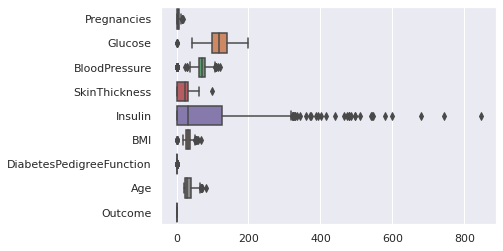

In [35]:
# View data distributions & detect outliers
sns.set()
sns.boxplot(data=df, orient='h')

Impute Missing Values

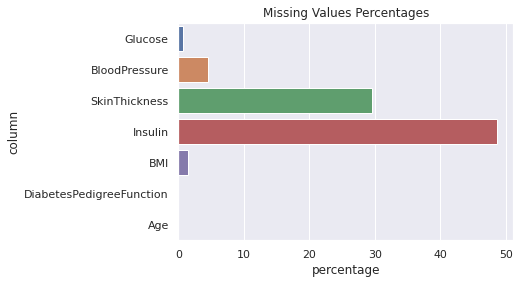

In [36]:
# Missing values interpreted as 0
# 0 values in 'Pregnancy' is not a missing value, it means that the woman is never pregnant
# Convert to categorical value 1, 0
df.Pregnancies = df.Pregnancies.astype(bool).astype(int)

# Convert zeros to NaN, count NaNs each columns and the percentages
rows = []
column = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction', 'Age']
for col in column:
    df[col] = df[col].replace(0,np.NaN)
    nans = df[col].isna().sum()
    percentage = ((nans / len(df)) * 100).round(2)
    rows.append([col, nans, percentage])
mv = pd.DataFrame(rows, columns=['column','nans','percentage'])

sns.set()
mv_p = sns.barplot(x='percentage', y='column', data=mv).set_title('Missing Values Percentages')

In [37]:
# Impute NaNs with median / mean
def fillna_median (col, df):
    df[col].fillna(df[col].median(), inplace = True)
    
def fillna_mean (col, df):
    df[col].fillna(df[col].mean(), inplace = True)

# Impute columns with outliers by median
fillna_median ('BloodPressure', df)
fillna_median ('SkinThickness', df)
fillna_median ('Insulin', df)
fillna_median ('BMI', df)

# Impute columns without outliers by mean
fillna_mean('Glucose', df)

df.isnull().values.any()

False

Clipping Outliers using Quantile-based Flooring and Capping

In [38]:
#Evaluating skewness in column with outliers
print(df['BloodPressure'].skew())
print(df['SkinThickness'].skew())
print(df['Insulin'].skew())
print(df['BMI'].skew())
print(df['Age'].skew())


0.1418850201030565
0.8376083316006523
3.380019128212173
0.599232520287425
1.1295967011444805


In [39]:
# Capping outliers, penalize only column with large skewness
print(df['Insulin'].quantile(0.90)) #huge skew level, proceed to cap. lowered from 3.3 to 0.14
df['Insulin'] = np.where(df['Insulin'] >210.0, 210.0,df['Insulin'])

print(df['SkinThickness'].quantile(0.90)) #wide gap from 75th percentile to the max value, proceed to cap
df['Insulin'] = np.where(df['Insulin'] >40.0, 40.0,df['Insulin'])

210.0
40.0


Normalization

In [40]:
# Calculate Z-scores of each column, except for label 'Outcome'
df_mean = df.mean()
df_std = df.std()
df_norm = (df - df_mean) / df_std
df_norm[['Pregnancies','Outcome']] = (df[['Pregnancies','Outcome']])
df_norm.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,0.864545,-0.031969,0.670206,0.125781,0.166511,0.468187,1.425067,1
1,1,-1.205376,-0.527975,-0.012293,0.125781,-0.851645,-0.364823,-0.190548,0
2,1,2.014501,-0.693310,-0.012293,0.125781,-1.331632,0.604004,-0.105515,1
3,1,-1.073952,-0.527975,-0.694792,0.125781,-0.633469,-0.920163,-1.040871,0
4,0,0.503130,-2.677331,0.670206,0.125781,1.548294,5.481337,-0.020483,1


Create Correlation Matrix to Know Correlating Features

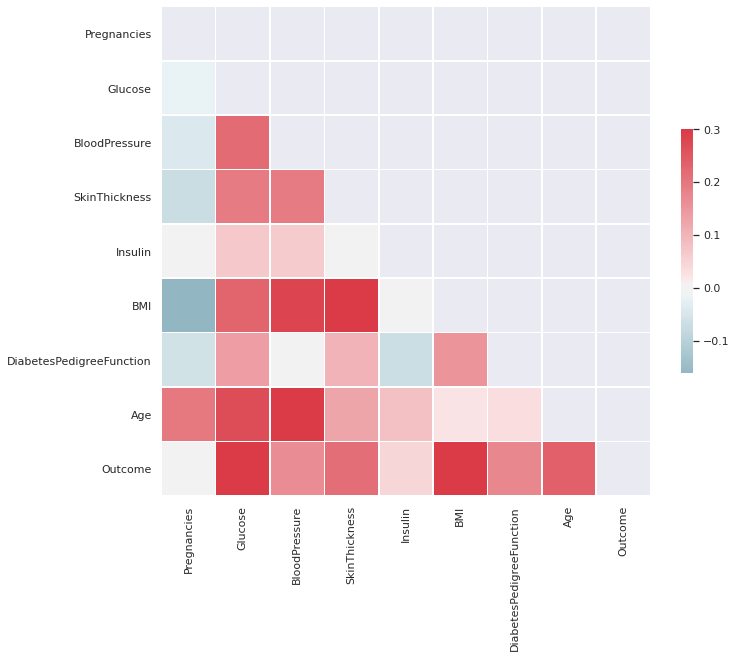

In [41]:
corr = df_norm.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Split dataset into train and test set

In [0]:
#df_norm = df_norm.reindex(np.random.permutation(df_norm.index)) # shuffling dataset
#train, test = train_test_split(df_norm, test_size=0.2)
#train, val = train_test_split(train, test_size=0.2)
#print(len(train), 'train examples')
#print(len(val), 'validation examples')
#print(len(test), 'test examples')

y = df_norm.Outcome #just for the splitting sakes
#X_train, X_test, y_train, y_test = train_test_split(df_norm, y, test_size=0.2, 
#                                                      random_state=42, 
 #                                                    shuffle = True)

In [0]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent Glucose.
glucose = tf.feature_column.numeric_column('Glucose')
feature_columns.append(glucose)

bmi = tf.feature_column.numeric_column('BMI')
feature_columns.append(bmi)

age = tf.feature_column.numeric_column('Age')
feature_columns.append(age)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
#feature_layer(dict(train_df_norm))

In [49]:
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, features, label, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  #features = {name:np.array(value) for name, value in dataset.items()}
  #label = np.array(features.pop(label_name))

  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, verbose=1)


  return history  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


In [45]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


In [50]:
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 700
batch_size = 100
label_name = 'Outcome'
classification_threshold = 0.4
y = df_norm.Outcome

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
           tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
           tf.keras.metrics.Recall(thresholds=classification_threshold,
                                 name='recall' 
                                 ),
          ]

# Train the model with K-Fold = 3
kf = KFold(3, random_state=327, shuffle = True)
batch = 1
for train_idx, val_idx in kf.split(df_norm, y):

    # Select the part of dataset to be train set-test set
    # according to indexes from K-Fold
    train_x = df_norm.iloc[train_idx]
    train_y = y[train_idx].to_numpy()
    val_x = df_norm.iloc[val_idx]
    val_y = y[val_idx].to_numpy()

    # Construct the model
    my_model = create_model(learning_rate, feature_layer, METRICS)

    # Converting train set into numpy formats
    train_features = {name:np.array(value) for name, value in train_x.items()}
    # Remove the label from the features
    train_label = train_y
    # Fit the data into the model
    history = train_model(my_model, train_features, train_label, epochs, label_name, batch_size)
    #history = train_model(my_model, X_train, epochs, label_name, batch_size)
    
    # Let's see the training result of this batch:
    train_res = my_model.evaluate(x=train_features, y=train_label, batch_size=batch_size)
    print("Train result:")
    print("Batch " + str(batch) +  " accuracy: " + "{:.00%}%".format(train_res[1]))
    print("Batch " + str(batch) +  " precision: " + "{:.00%}%".format(train_res[2]))
    print("Batch " + str(batch) +  " recall: " + "{:.00%}%".format(train_res[3]))
        
    # Let's see how it goes with the test set for this batch:
    test_features = {name:np.array(value) for name, value in val_x.drop(['Outcome'], axis = 1).items()}
    test_label = val_y 
    test_res = my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

    print("Test result:")
    print("Batch " + str(batch) +  " accuracy: " + "{:.00%}%".format(test_res[1]))
    print("Batch " + str(batch) +  " precision: " + "{:.00%}%".format(test_res[2]))
    print("Batch " + str(batch) +  " recall: " + "{:.00%}%".format(test_res[3]))
    
    # # The list of epochs is stored separately from the rest of history.
    # epochs = history.epoch

    # # Isolate the classification metric for each epoch.
    # hist = pd.DataFrame(history.history)
    
    # plot_curve(epochs, hist, METRICS)
    batch += 1


Epoch 1/700
6/6 [==============================] - 0s 2ms/step - loss: 0.8788 - accuracy: 0.3652 - precision: 0.2762 - recall: 0.5556
Epoch 2/700
6/6 [==============================] - 0s 2ms/step - loss: 0.8593 - accuracy: 0.3711 - precision: 0.2773 - recall: 0.5497
Epoch 3/700
6/6 [==============================] - 0s 2ms/step - loss: 0.8592 - accuracy: 0.3848 - precision: 0.2857 - recall: 0.5614
Epoch 4/700
6/6 [==============================] - 0s 2ms/step - loss: 0.8473 - accuracy: 0.3848 - precision: 0.2844 - recall: 0.5556
Epoch 5/700
6/6 [==============================] - 0s 2ms/step - loss: 0.8177 - accuracy: 0.3984 - precision: 0.2918 - recall: 0.5614
Epoch 6/700
6/6 [==============================] - 0s 2ms/step - loss: 0.8505 - accuracy: 0.4004 - precision: 0.2939 - recall: 0.5673
Epoch 7/700
6/6 [==============================] - 0s 2ms/step - loss: 0.8177 - accuracy: 0.4141 - precision: 0.3028 - recall: 0.5789
Epoch 8/700
6/6 [==============================] - 0s 2ms/step

Evaluate against test set